<a href="https://colab.research.google.com/github/huranokuma/simple_dcgan_test/blob/main/dcgan_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 画像の収集

### googleimagedownloadとChromeDriverのインストール

In [ ]:
!git clone https://github.com/Joeclinton1/google-images-download.git gid-joeclinton
!pip install -e gid-joeclinton

Cloning into 'gid-joeclinton'...
remote: Enumerating objects: 724, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 724 (delta 34), reused 47 (delta 29), pack-reused 666
Receiving objects: 100% (724/724), 335.70 KiB | 9.59 MiB/s, done.
Resolving deltas: 100% (424/424), done.
Obtaining file:///content/gid-joeclinton
     |████████████████████████████████| 979 kB 7.1 MB/s 
     |████████████████████████████████| 359 kB 34.1 MB/s 
     |████████████████████████████████| 138 kB 42.2 MB/s 
     |████████████████████████████████| 4.0 MB 47.5 MB/s 
     |████████████████████████████████| 55 kB 1.6 MB/s 
     |████████████████████████████████| 58 kB 4.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Running setup.py develop for google-images-download
ERROR: pip's dependency resolver does not currently take into

In [ ]:
!apt update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://security.ubuntu.c

### Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 画像を収集してGoogle Drive内に保存する

In [ ]:
import os
DIR = "drive/MyDrive/Colab Notebooks/dcgan/img"
if(os.path.isdir(DIR)==False):
  os.mkdir(DIR)
  print("==made DIR==")
else:
  print("==DIR already exists==")

==DIR already exists==


In [ ]:
!googleimagesdownload --keywords "顔 湯ノ花幽奈,顔 レム,顔 雨野狭霧,顔 平沢唯,顔 エミリア,顔 田井中律,顔 アクア,顔 川島緑輝,顔 和泉紗霧,顔 チノ(香風智乃),顔 御坂美琴,顔 アシリパ,顔 土間うまる,顔 リゼ(天々座理世),顔 各務原なでしこ,顔 小鳥遊六花,顔 高木さん,顔 木之本桜,顔 ナナリー・ランペルージ,顔 アスナ(結城明日奈),顔 鹿目まどか,顔 四方川菖蒲,顔 四方川菖蒲,顔 めぐみん,顔 羽瀬川小鳩,顔 志熊理科,顔 加藤恵,顔 アリス・カータレット,顔 黄前久美子,顔 琴吹紬,顔 栗山未来,顔 カンナカムイ,顔 桐咲千棘,顔 友利奈緒,顔 小野寺小咲,顔 高坂桐乃,顔 白鬼院凜々蝶,顔 秋山澪,顔 保登心愛,顔 灰原哀,顔 ラム,顔 本間芽衣子,顔 南ことり,顔 薙切えりな,顔 神裂火織,顔 東條希,顔 中野三玖,顔 ヴァイオレット・エヴァーガーデン,顔 中野五月,顔 中野二乃,顔 四宮かぐや,顔 リュー・リオン,顔 惣流・アスカ・ラングレー,顔 雪ノ下雪乃,顔 ナミ,顔 シノン（SAO）,顔 栗花落カナヲ,顔 胡蝶しのぶ,顔 竈門禰豆子,顔 ユウキ（SAO）,顔 千石撫子,顔 ボア・ハンコック,顔 中野四葉,顔 ラム（Re:ゼロから始める異世界生活）,顔 モモ・ベリア・デビルーク,顔 逢坂大河,顔 藤原千花,顔 イレイナ,顔 アリス・シンセシス・サーティ,顔 早坂愛,顔 中野梓,顔 白井黒子,顔 音無響子,顔 イリヤスフィール・フォン・アインツベルン,顔 由比ヶ浜結衣,顔 桜島麻衣,顔 早乙女らんま,顔 甘露寺蜜璃,顔 藤和エリオ,顔 ジュリエット・ペルシア,顔 胡蝶カナエ,顔 柏崎星奈,顔 千反田える,顔 比企谷小町,顔 水原千鶴,顔 綾波レイ,顔 月野うさぎ,顔 竜宮レナ,顔 牧之原翔子,顔 八九寺真宵,顔 一色いろは,顔 由崎司,顔 遠坂凛,顔 伊井野ミコ,顔 トガヒミコ,顔 椎名まゆり,顔 桐間紗路,顔 古河渚,顔 忍野忍,顔 ランカ・リー,顔 アイズ・ヴァレンシュタイン,顔 西木野真姫,顔 スヤリス姫,顔 渡辺曜,顔 ダクネス,顔 堀北鈴音,顔 シャルロット・デュノア,顔 ニコ・ロビン,顔 白（ノーゲーム・ノーライフ）,顔 秋月風夏,顔 釘崎野薔薇,顔 シェリル・ノーム,顔 月詠,顔 ベアトリス（Re:ゼロから始める異世界生活）,顔 耳郎響香,顔 立華かなで,顔 白鬼院凜々蝶,顔 我妻由乃,顔 ミカサ・アッカーマン,顔 翠星石,顔 白銀圭,顔 涼宮ハルヒ,顔 ウェンディ・マーベル,顔 園田海未,顔 楪いのり,顔 桐須真ルーシィ・ハートフィリア冬,顔 柊かがみ,顔 雪ノ下陽乃,顔 櫛枝実乃梨,顔 ターニャ・フォン・デグレチャフ,顔 西野つかさ,顔 小泉花陽,顔 牧瀬紅莉栖,顔 照橋心美,顔 笹川京子,顔 ネフェルタリ・ビビ,顔 ククリ,顔 エリス（このすば）,顔 ラクス・クライン,顔 宮園かをり,顔 真菰,顔 松浦果南,顔 恐山アンナ,顔 金剛,顔 ナディア・ラ・アルウォール,顔 鷹崎奈津,顔 犬塚つむぎ,顔 テレシア・ヴァン・アストレア,顔 澤村・スペンサー・英梨々,顔 更科瑠夏,顔 藤宮香織,顔 リナリー・リー,顔 宇佐美みずき,顔 軽井沢恵,顔 河合律,顔 白雪（赤髪の白雪姫）,顔 新垣あやせ,顔 白金燐子,顔 月乃瀬＝ヴィネット＝エイプリル,顔 長門有希,顔 桜内梨子,顔 ぼたん,顔 一之瀬帆波,顔 桐崎千棘,顔 木野まこと,顔 御坂妹,顔 ソフィア・アスカルト,顔 神崎アオイ,顔 小南桐絵,顔 アイラ（プラスティック・メモリーズ）,顔 サシャ・ブラウス,顔 ミュセル・フォアラン,顔 ラフタリア,顔 霞ヶ丘詩羽,顔 ミリム・ナーヴァ,顔 亜豆美保,顔 ノーマン（約束のネバーランド）,顔 葦月伊織,顔 杜山しえみ,顔 環古達,顔 優木せつ菜,顔 桜坂しずく,顔 暁凪沙,顔 椎名ましろ,顔 ナナチ,顔 ベルゼブブ,顔 神崎・H・アリア,顔 バラライカ,顔 江藤蘭世,顔 愛崎えみる,顔 羽沢つぐみ,顔 近江彼方,顔 ロニエ・アラベル,顔 平沢憂,顔 古橋文乃,顔 ツクモ,顔 天真＝ガヴリール＝ホワイト,顔 ルールー・アムール,顔 小野寺春,顔 五月七日くみん,顔 ナーベラル・ガンマ,顔 萩原雪歩,顔 柊シノア,顔 霧嶋董香,顔 今井信女,顔 さくら姫,顔 御原凛音,顔 暁美ほむら,顔 滝本ひふみ,顔 エマ（約束のネバーランド）,顔 高野千鶴,顔 狛井蓮季,顔 河了貂,顔 エヴァンジェリン・A・K・マクダウェル,顔 嘴平琴葉,顔 ゼロツー,顔 堀京子,顔 歳納京子,顔 オリヴィエ・ミラ・アームストロング,顔 川嶋亜美,顔 藤戸千雪,顔 絢辻詞,顔 愛野美奈子,顔 才賀しろがね,顔 佐倉杏子,顔 栗山未来,顔 クラリス・ド・カリオストロ,顔 織田信奈,顔 珠世,顔 ルイズ・フランソワーズ,顔 唐之杜志恩,顔 藤堂ユリカ,顔 三千院ナギ,顔 アルクェイド,顔 リーファ（SAO）,顔 古手梨花,顔 蛇喰夢子,顔 三色院菫子,顔 美島奈々,顔 南ことり,顔 桜沢墨,顔 アーニャ・フォージャー,顔 氷室菖蒲,顔 レイ（約束のネバーランド）,顔 櫻田岬,顔 コハク,顔 乃木園子,顔 八百万百,顔 クルシュ・カルステン,顔 高槻やよい,顔 エルザ・スカーレット,顔 ベアトリス（レ・ミゼラブル 少女コゼット）,顔 黒雪姫,顔 国木田花丸,顔 豊浜のどか葛城ミサト,顔 夢見りあむ,顔 船見結衣,顔 西連寺春菜,顔 エルピー・プル,顔 海老名菜々,顔 タカヤ・ノリコ,顔 キャロル・マールス・ディーンハイム,顔 東本願早苗,顔 渋谷凛,顔 奈瀬明日美,顔 エアリス・ゲインズブール,顔 トリッシュ・ウナ,顔 棗鈴,顔 草壁サツキ,顔 妓夫太郎,顔 高坂麗奈,顔 七海春歌,顔 冬海愛衣,顔 宮子,顔 橘瑠衣,顔 アリス（神様のメモ帳）,顔 イカ娘,顔 東城綾,顔 綾瀬千早,顔 川本ひなた,顔 白石結月" -o "/content/drive/MyDrive/Colab Notebooks/dcgan/img" -l 100 -f "jpg" --chromedriver /usr/bin/chromedriver
# 検索したい言葉を""の中に入れる"
# デフォルトでは集めてきた画像をGoogle Colabのフォルダ内に保存する

## Ganの訓練

### 準備

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-b3b83cdd-ed48-c521-ecb8-9b672b55da94)


In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import (Dataset, 
                              DataLoader,
                              TensorDataset)
import tqdm
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import os
if(os.path.isdir("/content/drive/MyDrive/Colab Notebooks/dcgan/result")==False):
  os.mkdir("/content/drive/MyDrive/Colab Notebooks/dcgan/result")
  print("==made dcgan/result!==")

if(os.path.isdir("/content/drive/MyDrive/Colab Notebooks/dcgan/result/g")==False):
  os.mkdir("/content/drive/MyDrive/Colab Notebooks/dcgan/result/g")
  print("==made dcgan/result/g!==")

if(os.path.isdir("/content/drive/MyDrive/Colab Notebooks/dcgan/result/d")==False):
  os.mkdir("/content/drive/MyDrive/Colab Notebooks/dcgan/result/d")
  print("==made dcgan/result/d!==")

if(os.path.isdir("/content/drive/MyDrive/Colab Notebooks/dcgan/result/img_raw")==False):
  os.mkdir("/content/drive/MyDrive/Colab Notebooks/dcgan/result/img_raw")  
  print("==made result/img_raw!==")
  
if(os.path.isdir("/content/drive/MyDrive/Colab Notebooks/dcgan/result/img")==False):
  os.mkdir("/content/drive/MyDrive/Colab Notebooks/dcgan/result/img")  
  print("==made result/img!==")

In [ ]:
# ipynbファイルがあるときはgoogle driveから削除しないとエラーが出る
img_data = ImageFolder("/content/drive/MyDrive/Colab Notebooks/dcgan/img",
    transform=transforms.Compose([
        transforms.Resize(80),
        transforms.CenterCrop(64),#画像を64pxにする
        transforms.ToTensor()
]))

batch_size = 64
img_loader = DataLoader(img_data, batch_size=batch_size,
                        shuffle=True)

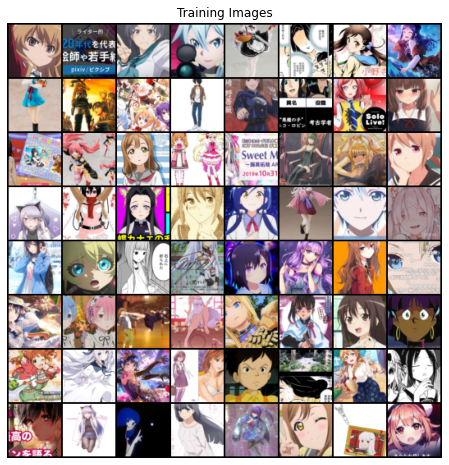

In [ ]:
# 訓練用の画像の何枚かを表示する
real_batch = next(iter(img_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to("cuda:0")[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### モデルの定義

In [ ]:
nz = 100
ngf = 32

class GNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 
                               4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 2, ngf,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf, 3,
                               4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        out = self.main(x)
        return out

In [ ]:
ndf = 32

class DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        out = self.main(x)
        return out.squeeze()

In [ ]:
from statistics import mean

def train_dcgan(g, d, opt_g, opt_d, loader):
    # 生成モデル、識別モデルの目的関数の追跡用の配列
    log_loss_g = []
    log_loss_d = []
    for real_img, _ in tqdm.tqdm(loader):
        batch_len = len(real_img)
        
         # 実際の画像をGPUにコピー
        real_img = real_img.to("cuda:0")
        
         # 偽画像を乱数と生成モデルから作る
         # これを用いることであとでモデルから関数として画像を次々と生み出すことができる？
        z = torch.randn(batch_len, nz, 1, 1).to("cuda:0")
        fake_img = g(z)
        
        # 後で使用するので偽画像の値のみ取り出しておく
        fake_img_tensor = fake_img.detach()
        
        # 偽画像に対する生成モデルの評価関数を計算する
        out = d(fake_img)
        loss_g = loss_f(out, ones[: batch_len])
        log_loss_g.append(loss_g.item())
        
        # 計算グラフが生成モデルと識別モデルの両方に
        # 依存しているので両者とも勾配をクリアしてから
        # 微分の計算とパラメータ更新を行う
        d.zero_grad(), g.zero_grad()
        loss_g.backward()
        opt_g.step()

        # 実際の画像に対する識別モデルの評価関数を計算
        real_out = d(real_img)
        loss_d_real = loss_f(real_out, ones[: batch_len])
        
        # PyTorchでは同じTensorを含んだ計算グラフに対して
        # 2回backwardを行うことができないので保存してあった
        # Tensorを使用して無駄な計算を省く
        fake_img = fake_img_tensor
        
        # 偽画像に対する識別モデルの評価関数の計算
        fake_out = d(fake_img_tensor)
        loss_d_fake = loss_f(fake_out, zeros[: batch_len])
        
        # 実偽の評価関数の合計値
        loss_d = loss_d_real + loss_d_fake
        log_loss_d.append(loss_d.item())
        
        # 識別モデルの微分計算とパラメータ更新
        d.zero_grad(), g.zero_grad()
        loss_d.backward()
        opt_d.step()
        
    return mean(log_loss_g), mean(log_loss_d)

In [ ]:
#モデルの作成
d = DNet().to("cuda:0")
g = GNet().to("cuda:0")

### Training

In [ ]:
# Adamのパラメーター

learning_rate = 0.002 #@param {type:"number"}
beta_1 = 0.9 #@param {type:"number"}
beta_2 = 0.999 #@param {type:"number"}

opt_d = optim.Adam(d.parameters(),
    lr=learning_rate, betas=(beta_1, beta_2))
opt_g = optim.Adam(g.parameters(),
    lr=learning_rate, betas=(beta_1, beta_2))

# クロスエントロピーを計算するための補助変数など
ones = torch.ones(batch_size).to("cuda:0")
zeros = torch.zeros(batch_size).to("cuda:0")
loss_f = nn.BCEWithLogitsLoss()

# モニタリング用のz
fixed_z = torch.randn(batch_size, nz, 1, 1).to("cuda:0")

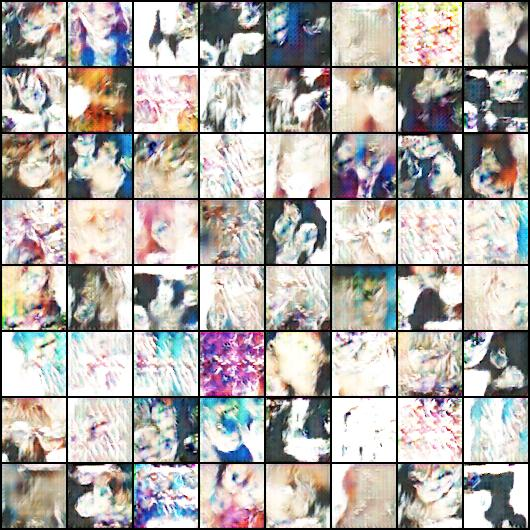

 58%|█████▊    | 94/163 [02:03<01:36,  1.40s/it]

In [ ]:
from IPython.display import Image,display_jpeg,clear_output


num_epochs=10000 #@param {type:"number"}
save_every_epoch = 10 #@param {type:"number"}


for epoch in range(num_epochs):
    train_dcgan(g, d, opt_g, opt_d, img_loader)
    # save_every_epoch回の繰り返しごとにモデルを保存する
    if epoch % save_every_epoch == 0:
        # モニタリング用のzから生成した画像を保存
        generated_img = g(fixed_z)
        save_image(generated_img,
                   "/content/drive/MyDrive/Colab Notebooks/dcgan/result/img_raw/{:03d}.jpg".format(epoch))
        clear_output()
        display_jpeg(Image("/content/drive/MyDrive/Colab Notebooks/dcgan/result/img_raw/{:03d}.jpg".format(epoch)))
        # パラメータの保存
        torch.save(
            g.state_dict(),
            "/content/drive/MyDrive/Colab Notebooks/dcgan/result/g/g_{:03d}.prm".format(epoch),
            pickle_protocol=4)
        torch.save(
            d.state_dict(),
            "/content/drive/MyDrive/Colab Notebooks/dcgan/result/d/d_{:03d}.prm".format(epoch),
            pickle_protocol=4)
    #if epoch % 100 == 0:
        #for i in range(64):
            #save_image(generated_img[i],
                       #f"/content/drive/MyDrive/Colab Notebooks/dcgan/result/img/{epoch}_{i}.jpg")  

## 訓練済みモデルの読み込み

In [ ]:
# モデルの読み込み　パスは保存したモデルのパスを利用する
param_d = torch.load("/content/drive/MyDrive/Colab Notebooks/dcgan/prm/d_v7.prm")
param_g = torch.load("/content/drive/MyDrive/Colab Notebooks/dcgan/prm/g_v7.prm")

In [ ]:
d = DNet().to("cuda:0")
g = GNet().to("cuda:0")

In [ ]:
d.load_state_dict(param_d)
g.load_state_dict(param_g)

<All keys matched successfully>

In [ ]:
#一応念のために...
for p in d.parameters():
  p.requires_grad=True
for p in g.parameters():
  p.requires_grad=True